In [180]:
import os
from datetime import datetime


def find_latest_result():
    # Define the root directory to start the search
    root_dir = 'results/cellphy_toy_data'

    # Initialize variables to keep track of the latest file and its creation date
    latest_file = None
    latest_date = datetime.min

    # Walk through the directory tree and search for the file
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename == 'results.p':
                file_path = os.path.join(dirpath, filename)
                creation_date = datetime.fromtimestamp(os.path.getctime(file_path))
                if creation_date > latest_date:
                    latest_file = file_path
                    latest_date = creation_date
    
    return latest_file


result_path = find_latest_result()
print(result_path)

results/cellphy_toy_data/False/300/2023-11-04-043833/results.p


In [181]:
import pickle
import numpy as np
import json

In [182]:
with open('data/cellphy_toy_set.phy', 'r') as f:
    phy_file_raw = f.readlines()

labels = [line.split(' ')[0] for line in phy_file_raw[1:]]
labels += ["Dummy"]

In [183]:
with open(result_path, 'rb') as f:
    data = pickle.load(f)

data["best_jump_chain"].shape

(300, 325)

In [184]:
best_arg_sort = np.argsort(data["best_log_lik"])[::-1]
best_jc_list = data["best_jump_chain"]
best_left_branches_list = np.transpose(data["left_branches"][data["best_epoch"]])
best_right_branches_list = np.transpose(data["right_branches"][data["best_epoch"]])

In [185]:
class Leaf:
    def __init__(self, value):
        self.value = value
        self.parent = None

    def has(self, value):
        return self.value == value
    
    def find(self, value):
        if self.value == value:
            return self
        else:
            return None

    def __str__(self):
        return str(self.value)

class Inner:
    def __init__(self, left, right, left_len, right_len):
        self.left = left
        self.right = right

        self.left_len = left_len
        self.right_len = right_len

        left.parent = self
        left.parent_len = left_len
        right.parent = self
        right.parent_len = right_len

        self.parent = None
        self.parent_len = None

    def has(self, value):
        return self.left.has(value) or self.right.has(value)
    
    def find(self, value):
        return self.left.find(value) or self.right.find(value)

    def __str__(self):
        return f"({self.left}:{np.log(self.left_len+1)},{self.right}:{np.log(self.right_len+1)})"

def build_tree(jc, left_branches, right_branches):
    """Returns the Newick representation of the tree represented by the jump chain"""

    parsed = [tuple((labels[int(y[1:])] for y in str(x)[2:-1].split("+"))) for x in jc[1:]]

    entries = []
    seen = set()

    for entry in parsed:
        if entry in seen:
            continue

        seen.add(entry)
        entries.append(entry)
    
    print(entries)
    
    trees = []

    merge_index = 0

    for entry in entries:
        if len(entry) == 1:
            trees.append(Leaf(entry[0]))
        else:
            trees_to_merge = list(filter(lambda x: True in map(lambda y: x.has(y), entry), trees))
            if len(trees_to_merge) != 2:
                raise Exception("too many trees to merge")
                # print(f"Warning, skipping merging {len(trees_to_merge)} trees")
                continue

            new_inner = Inner(trees_to_merge[0], trees_to_merge[1], left_branches[merge_index], right_branches[merge_index])
            trees = list(filter(lambda x: x not in trees_to_merge, trees))
            trees.append(new_inner)

            merge_index += 1

    if len(trees) == 1:
        return trees[0]
    if len(trees) == 2:
        return Inner(trees[0], trees[1], left_branches[merge_index], right_branches[merge_index])
    else:
        raise Exception("too many trees to merge")


def build_best_tree():
    for i in best_arg_sort:
        print(f"Building tree with likelihood {data['best_log_lik'][i]}")
        try:
            return build_tree(best_jc_list[i], best_left_branches_list[i], best_right_branches_list[i])
        except:
            print("Warning, current tree failed to build, so trying next best tree\n")
    
    raise Exception("No tree could be built")

In [186]:
def re_root_tree(node, parent):
    if not node:
        return Leaf("Dummy")
    elif isinstance(node, Leaf):
        return node
    elif node.left == parent:
        return Inner(re_root_tree(node.right, node), re_root_tree(node.parent, node), node.right_len, node.parent_len or 0)
    elif node.right == parent:
        return Inner(re_root_tree(node.left, node), re_root_tree(node.parent, node), node.left_len, node.parent_len or 0)
    else: # node.parent == parent
        return node

Building tree with likelihood -7693.717259380997
[('TI-TNS10',), ('TI-TNS11',), ('TI-TNS12',), ('TI-TNS16',), ('TI-TNS17',), ('TI-TNS18',), ('TI-TNS2',), ('TI-TNS3',), ('TI-TNS4',), ('TI-TNS9',), ('TI-TS10',), ('TI-TS11',), ('TI-TS12',), ('TI-TS13',), ('TI-TS14',), ('TI-TS17',), ('TI-TS2',), ('TI-TS5',), ('TM-TNS3',), ('TM-TS11',), ('TM-TS17',), ('TM-TS20',), ('TM-TS4',), ('TM-TS5',), ('Healthy',), ('TI-TS13', 'TM-TS11'), ('TM-TNS3', 'TI-TNS12'), ('TI-TS13', 'TM-TS11', 'TI-TS11'), ('TM-TNS3', 'TI-TNS12', 'TI-TS10'), ('TI-TNS4', 'TM-TNS3', 'TI-TNS12', 'TI-TS10'), ('TI-TS2', 'TI-TS13', 'TM-TS11', 'TI-TS11'), ('TI-TS5', 'TI-TS2', 'TI-TS13', 'TM-TS11', 'TI-TS11'), ('TM-TS17', 'TI-TNS17'), ('TI-TS5', 'TI-TS2', 'TI-TS13', 'TM-TS11', 'TI-TS11', 'TI-TNS10'), ('TI-TS5', 'TI-TS2', 'TI-TS13', 'TM-TS11', 'TI-TS11', 'TI-TNS10', 'TM-TS20'), ('TI-TNS4', 'TM-TNS3', 'TI-TNS12', 'TI-TS10', 'TI-TS5', 'TI-TS2', 'TI-TS13', 'TM-TS11', 'TI-TS11', 'TI-TNS10', 'TM-TS20'), ('TI-TS12', 'TI-TNS9'), ('TI-TNS4', 'T

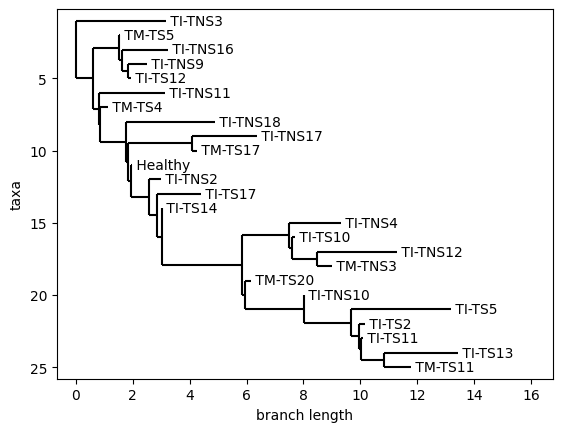

In [187]:
from Bio import Phylo
import io
import matplotlib.pyplot as plt

# Define your tree in Newick format
root = build_best_tree()

# Parse the tree
tree = Phylo.read(io.StringIO(str(root)), "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()

Building tree with likelihood -7693.717259380997
[('TI-TNS10',), ('TI-TNS11',), ('TI-TNS12',), ('TI-TNS16',), ('TI-TNS17',), ('TI-TNS18',), ('TI-TNS2',), ('TI-TNS3',), ('TI-TNS4',), ('TI-TNS9',), ('TI-TS10',), ('TI-TS11',), ('TI-TS12',), ('TI-TS13',), ('TI-TS14',), ('TI-TS17',), ('TI-TS2',), ('TI-TS5',), ('TM-TNS3',), ('TM-TS11',), ('TM-TS17',), ('TM-TS20',), ('TM-TS4',), ('TM-TS5',), ('Healthy',), ('TI-TS13', 'TM-TS11'), ('TM-TNS3', 'TI-TNS12'), ('TI-TS13', 'TM-TS11', 'TI-TS11'), ('TM-TNS3', 'TI-TNS12', 'TI-TS10'), ('TI-TNS4', 'TM-TNS3', 'TI-TNS12', 'TI-TS10'), ('TI-TS2', 'TI-TS13', 'TM-TS11', 'TI-TS11'), ('TI-TS5', 'TI-TS2', 'TI-TS13', 'TM-TS11', 'TI-TS11'), ('TM-TS17', 'TI-TNS17'), ('TI-TS5', 'TI-TS2', 'TI-TS13', 'TM-TS11', 'TI-TS11', 'TI-TNS10'), ('TI-TS5', 'TI-TS2', 'TI-TS13', 'TM-TS11', 'TI-TS11', 'TI-TNS10', 'TM-TS20'), ('TI-TNS4', 'TM-TNS3', 'TI-TNS12', 'TI-TS10', 'TI-TS5', 'TI-TS2', 'TI-TS13', 'TM-TS11', 'TI-TS11', 'TI-TNS10', 'TM-TS20'), ('TI-TS12', 'TI-TNS9'), ('TI-TNS4', 'T

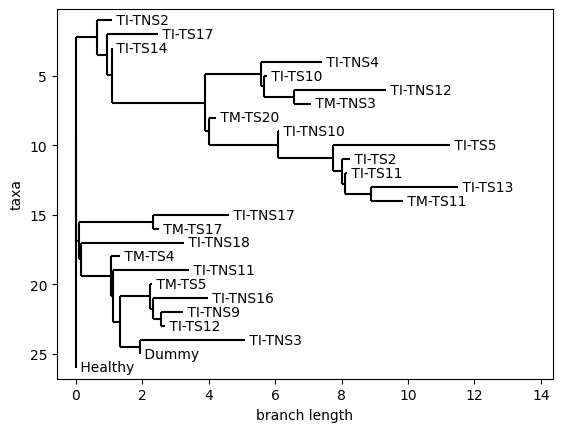

In [188]:
root = build_best_tree()
healthy = root.find("Healthy")
new_root = re_root_tree(healthy.parent, healthy)
new_root = Inner(new_root, healthy, 0, 0)

# Parse the tree
tree = Phylo.read(io.StringIO(str(new_root)), "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()